<a href="https://colab.research.google.com/github/Avinashpv87/cs666student/blob/main/CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

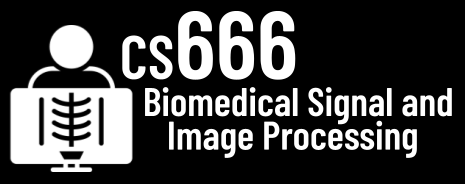
# Assignment 6

In [64]:
# NAME:Avinash Pamidimukkala

In [65]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [66]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [67]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [68]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-24 19:56:12--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.1’

mito.npz.1          100%[===================>]  35.87M   118MB/s    in 0.3s    

2023-04-24 19:56:14 (118 MB/s) - ‘mito.npz.1’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [70]:
# The data includes images and manually segmented masks.
import numpy as np
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

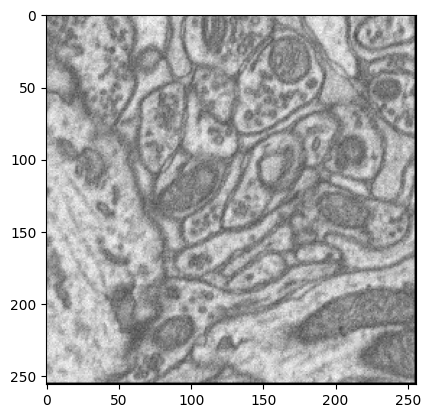

In [71]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
import matplotlib.pyplot as plt
plt.imshow(images[0], cmap = 'gray')

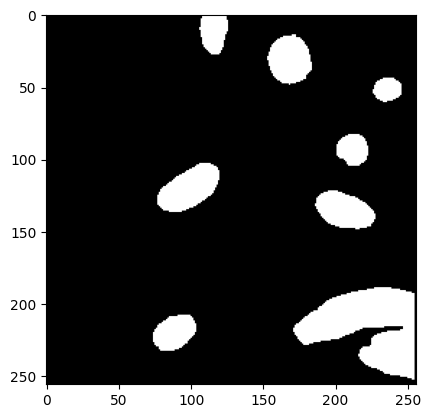

In [72]:
# TODO: Show the first mask.
plt.imshow(masks[0], cmap='gray')

## 1. SAM in AUTO mode (15 points)

In [73]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [75]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [76]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


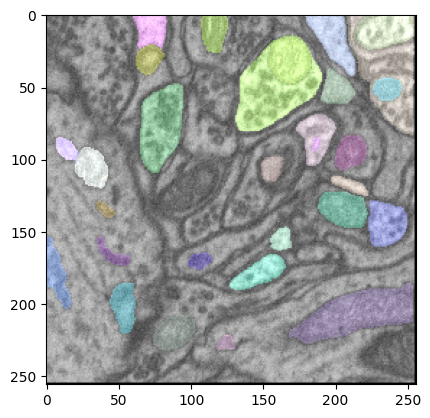

In [77]:
plt.imshow( mh.imread('first_output.png') )

In [78]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER
#YES

In [79]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_l model already exists as 'vit_l.pth'. Skipping download.


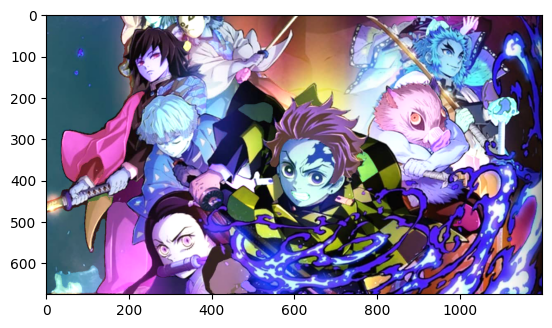

In [83]:
# TODO: YOUR CODE
from PIL import Image 
img = Image.open('demonslayer.jpg')
img_array = np.array(img)
mh.imsave('second.png', img_array)
results = SegAutoMaskPredictor().image_predict(
    source="second.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)
plt.imshow( mh.imread('second_output.png') )

In [20]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER
#YES

## 2. Train a U-Net classifier from scratch (50 points)


In [84]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

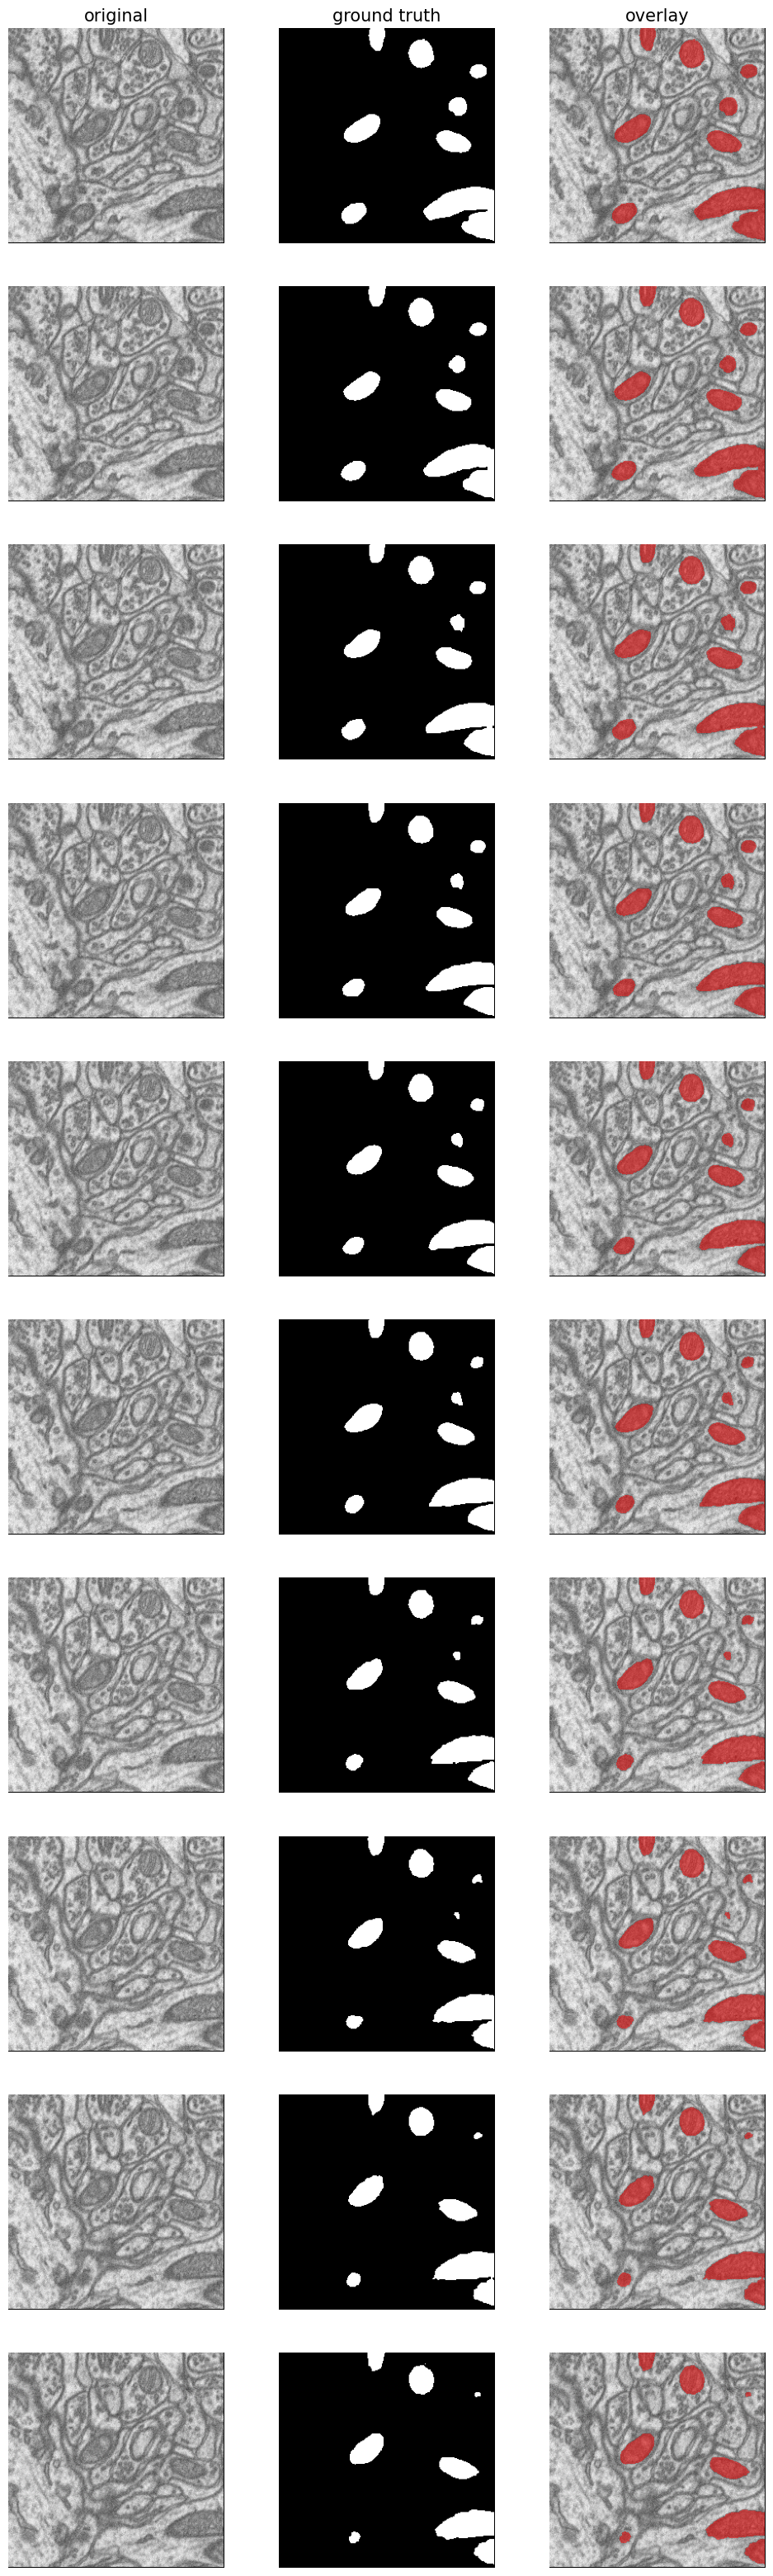

In [23]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [86]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [87]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
X = images.astype('float32')
X = (X - X.min()) / (X.max() - X.min())
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

In [88]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [89]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [91]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
y = masks.astype('float32')
y = (y - y.min()) / (y.max() - y.min())
y = y.astype(bool)
y = y.reshape((y.shape[0], y.shape[1], y.shape[2], 1))

In [92]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [93]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [96]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [97]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER
# for the first split, we split the data into trian(80% of data) and test(20% of data)
# for the second split, we split the data into train(70% of previous train data) and validation(30% of previous train data).

In [98]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [99]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER
# train_gen: This creates a variable train_gen which will hold the generator object that is returned by the get_augmented() function.

# get_augmented(): This is a function that takes in X_train, y_train, and batch_size as arguments, along with a dictionary data_gen_args containing various augmentation parameters.
# X_train, y_train: data for the moedl. 
# batch_size=2: Tthe number of samples per batch that will be used.
# rotation_range=15.: maximum angle in degrees by which the input images can be randomly rotated.
# width_shift_range=0.05: maximum fraction of total width by which the input images can be randomly shifted horizontally.
# height_shift_range=0.05: maximum fraction of total height by which the input images can be randomly shifted vertically.
# shear_range=50: maximum angle in degrees by which the input images can be randomly sheared.
# zoom_range=0.2: maximum zoom-in or zoom-out factor by which the input images can be randomly zoomed.
# horizontal_flip=True: whether or not to randomly flip the input images horizontally.
# vertical_flip=True: whether or not to randomly flip the input images vertically.
# fill_mode='constant': This specifies the method to use for filling in any new pixels that are created during the augmentation process. 
# In this case, 'constant' is used to fill in new pixels with a constant value.

(2, 256, 256, 1) (2, 256, 256, 1)


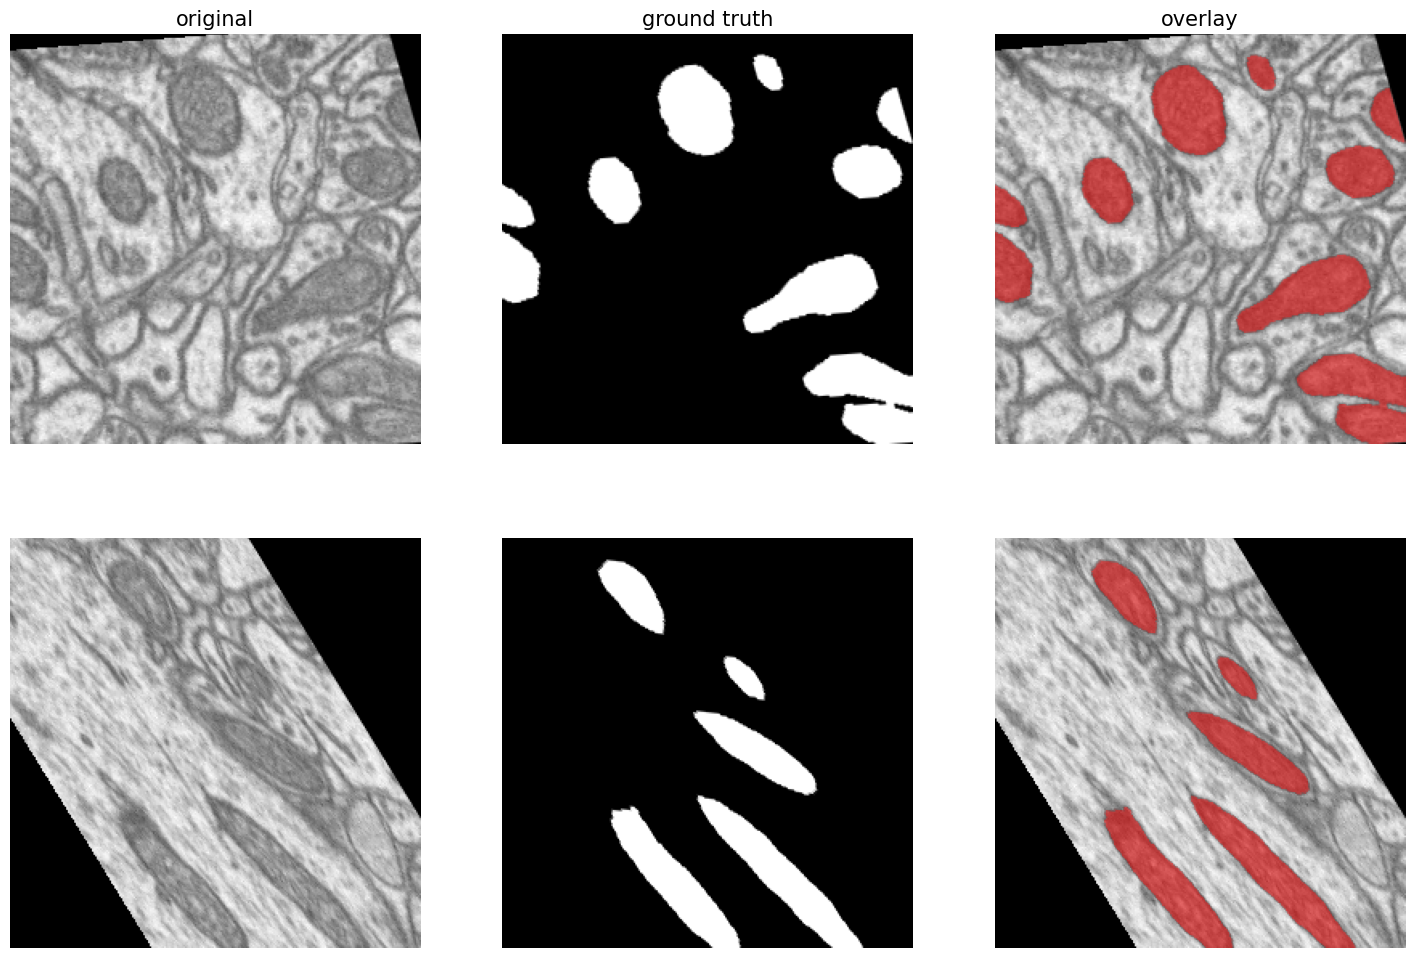

In [100]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [101]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [102]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d_5 (SpatialDr  (None, 256, 256, 64  0          ['conv2d_19[0][0]']              
 opout2D)                       )                                                           

# 31,030,593 parameters

In [103]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [104]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [105]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER
# It measures the similarity between two sets of bounding boxes or masks by computing the ratio of the intersection area 
# to the union area between the sets. A higher IoU score indicates better overlap between the predicted and ground-truth 
# bounding boxes or masks

In [106]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    #
    # TODO: YOUR CODE
    #
    train_gen, 
    validation_data = (X_val, y_val),
    epochs = 30, 
    steps_per_epoch = X_train.shape[0] // 2
)

Epoch 1/30
184/184 [==============================] - 31s 158ms/step - loss: 0.2553 - iou: 0.0465 - iou_thresholded: 2.6685e-04 - val_loss: 0.2570 - val_iou: 0.0519 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
184/184 [==============================] - 29s 159ms/step - loss: 0.1928 - iou: 0.0964 - iou_thresholded: 0.0115 - val_loss: 0.2130 - val_iou: 0.0968 - val_iou_thresholded: 6.0699e-06
Epoch 3/30
184/184 [==============================] - 29s 158ms/step - loss: 0.1682 - iou: 0.1339 - iou_thresholded: 5.4596e-04 - val_loss: 0.2405 - val_iou: 0.0655 - val_iou_thresholded: 6.0699e-06
Epoch 4/30
184/184 [==============================] - 29s 159ms/step - loss: 0.1710 - iou: 0.1269 - iou_thresholded: 0.0292 - val_loss: 0.1826 - val_iou: 0.1331 - val_iou_thresholded: 6.0699e-06
Epoch 5/30
184/184 [==============================] - 29s 160ms/step - loss: 0.1427 - iou: 0.2288 - iou_thresholded: 0.2176 - val_loss: 0.1274 - val_iou: 0.3092 - val_iou_thresholded: 0.4211
Epoch 6/30
184/184 [=

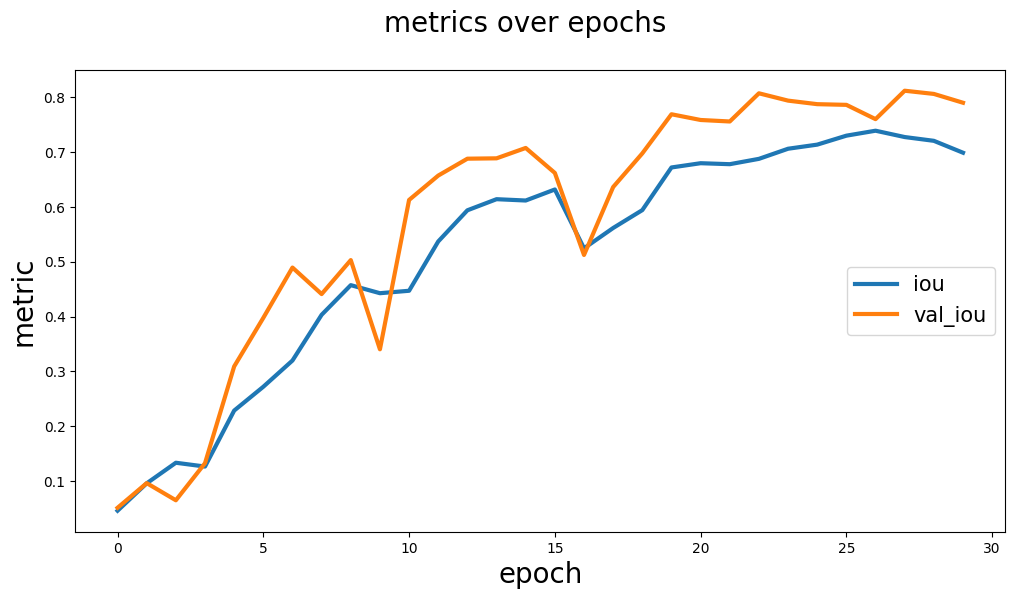

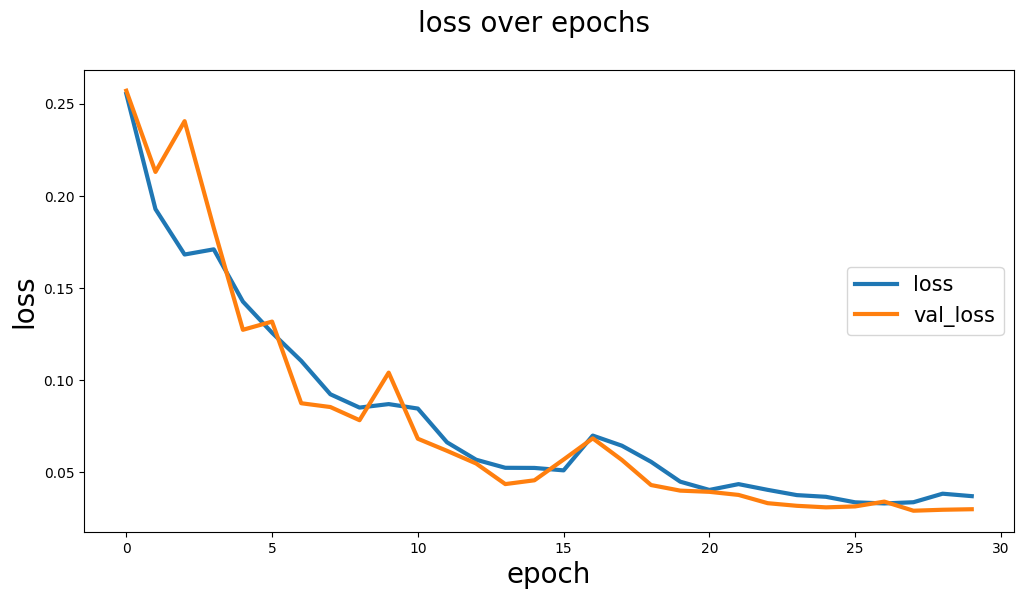

In [108]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [46]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER
#YES

## 3. Evaluate U-Net (10 points)

In [110]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 2s 412ms/step


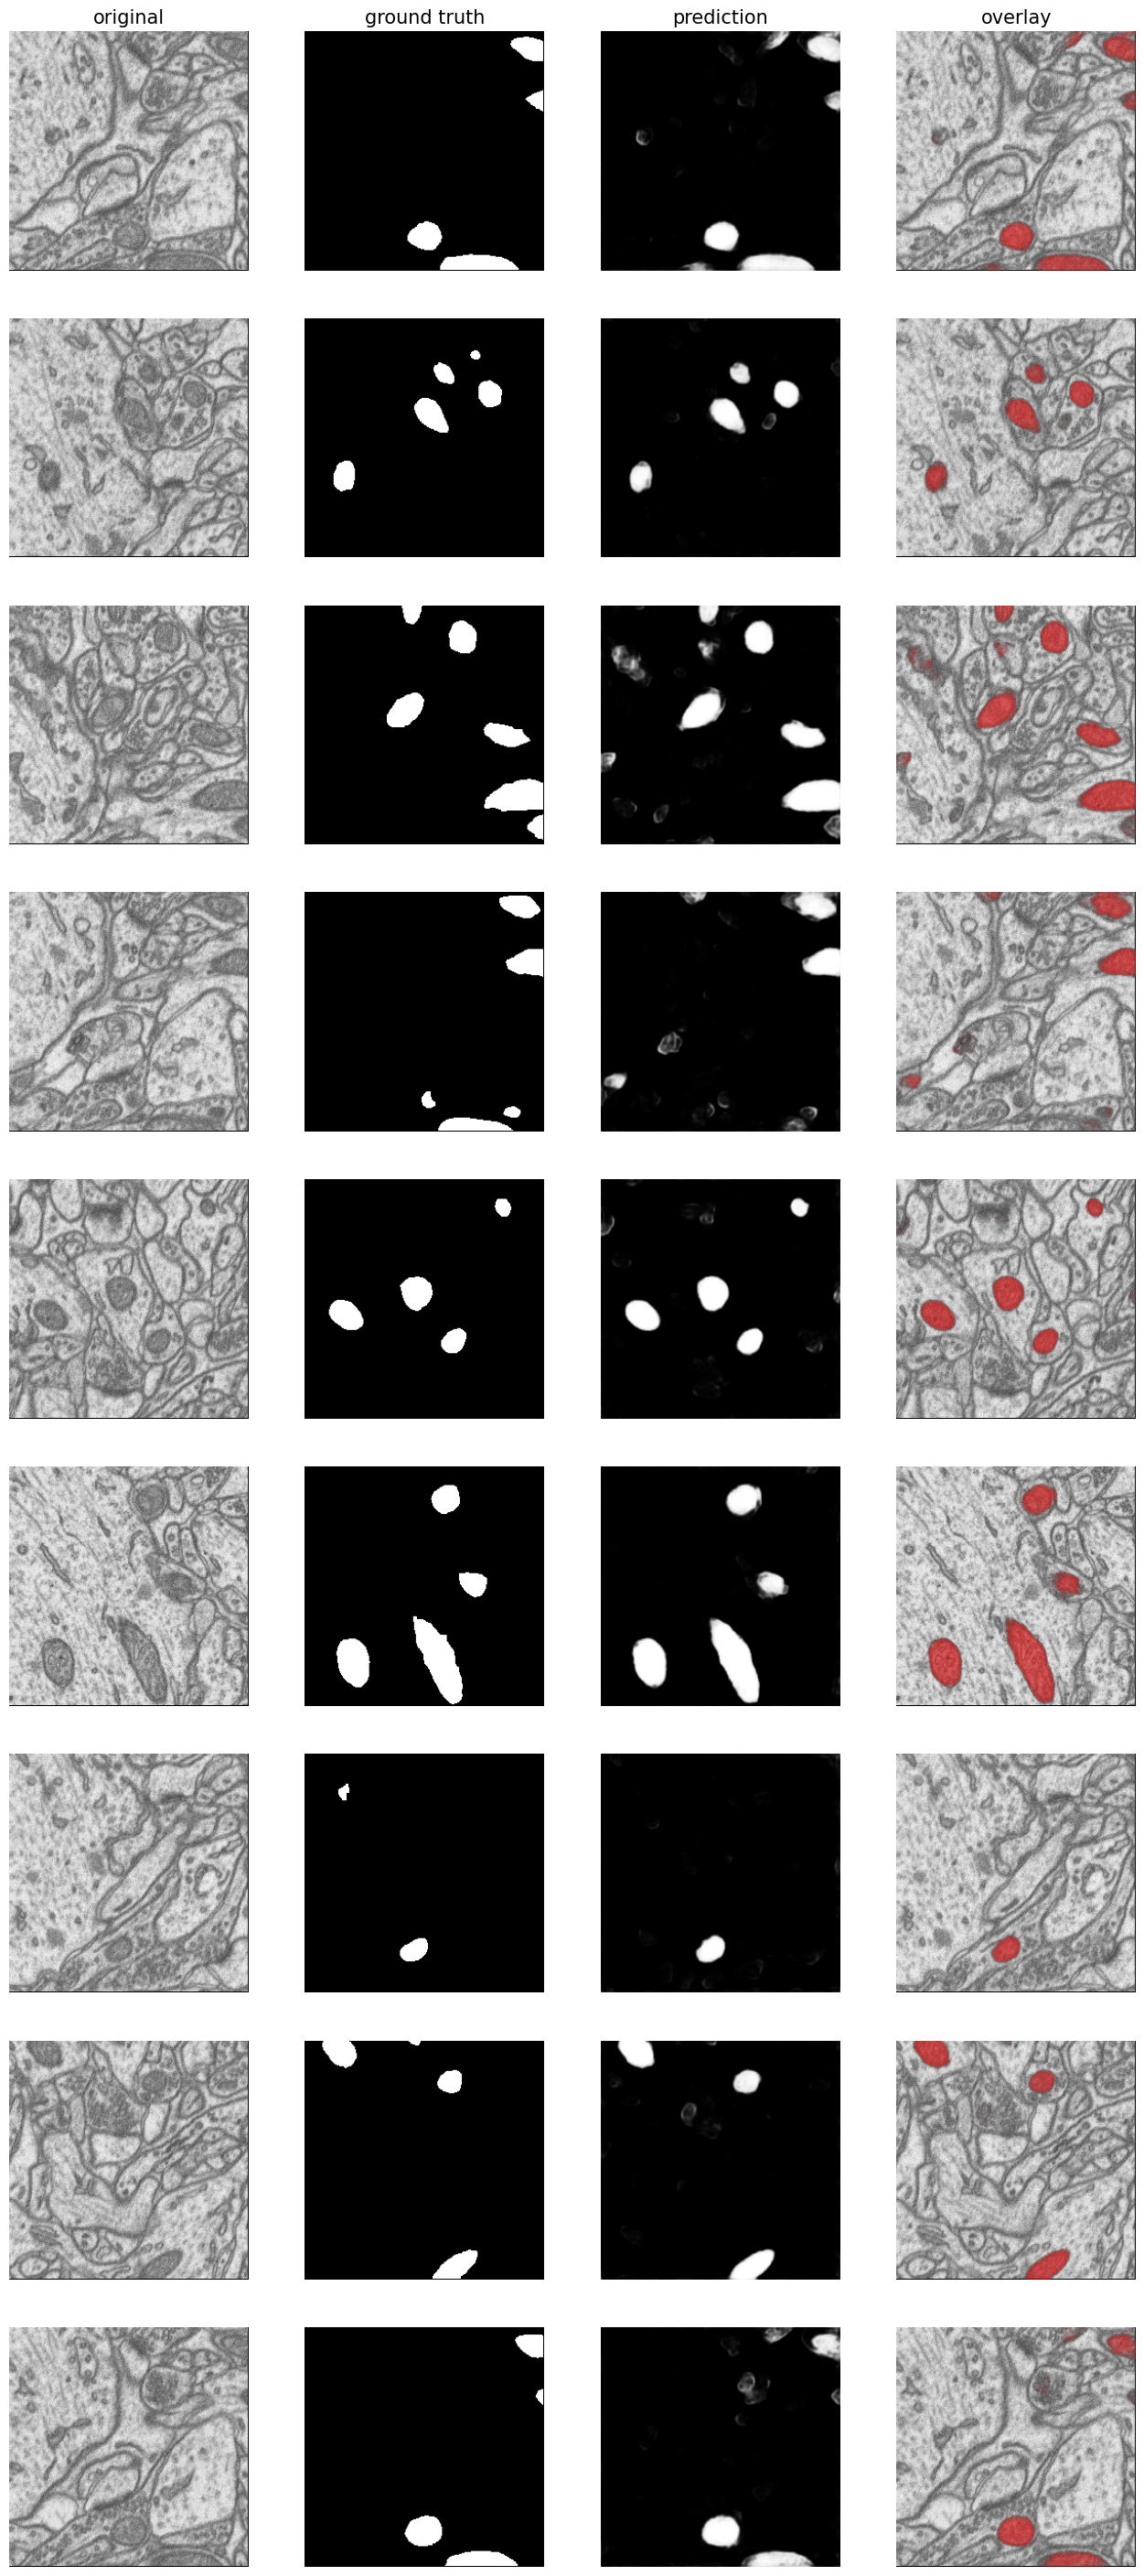

In [111]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [112]:
import sklearn.metrics

In [113]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8612186833162095

In [114]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 
# Jaccard Score is defined as the ratio of the intersection area to the union area 
# between two sets. It is a measure of how similar the two sets are.
#  IoU measures the overlap between two sets as the ratio of the intersection area to the combined area of the two sets. 
# This means that IoU penalizes the predictions more if they have a larger area than the ground-truth.

In [115]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER
#YES

## 4. Combine U-Net with SAM (10 points)

In [116]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [117]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [118]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [119]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [120]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [121]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  # The first channel of the image RGB is scaled to 0-255 and convert to unit8 datatype.
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  # creates a binary mask for the predicted output 
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  # get the predicted label(an unique integer) from the mask created
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  #  this computes the bounding box coordinates for each connected component
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  # converts bounding box coordinates from the format 
  # [min_row, min_col, max_row, max_col] to the format [min_col, min_row, max_col, max_row]
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  # this predicts the segmentation mask for the images, 
  # model_type: the type of pre-trained vision transformer model to use.
  # input_box: a list of bounding box coordinates
  # multimask_output: a boolean flag that specifies whether to return a single segmentation mask 
  # random_color: a boolean flag that specifies whether to assign a random color
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  #converting the output of the segmentation to a binary mask which is compatible with the output of a U-Net model.
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  # assigning the binary mask to a slice of a 4D numpy array y_pred_sam.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [122]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8612186833162095

In [123]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8497576426123139

In [124]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER
#The jaccard score for U-Net is high. No, addition of U-Net+SAM seems to under perform.

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [131]:
# TODO: YOUR_CODE
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  pred = (y_pred[z] > 0.7)
  pred, _ = mh.labeled.label(pred)
  bbs = mh.labeled.bbox(pred)
  bbs_converted = mahotas_bbox_to_sam(bbs)
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  sam_and_unet_pred = sam_to_mask(results)
  y_pred_sam[z,:,:,0] = sam_and_unet_pred
  sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [132]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8509034800432642

In [62]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#